In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10
numpyro.set_host_device_count(n_chains)

In [5]:
seed = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
import pickle
from dataclasses import dataclass
from typing import Any, Sequence
from jaxtyping import PyTree, Float, Array
from flax import linen as nn
from jax.nn import sigmoid

@dataclass
class Surrogate():
    model: Any
    params: PyTree
    param_keys: Sequence[str]
    param_stats: Sequence[Float[Array, 'input_dim']]
    output_ranges: Sequence[Sequence[int]]
    output_stats: Sequence[Sequence[Float[Array, 'output_dim']]]
    
    def run(self, p):
        input_array = jnp.array([p[k] for k in self.param_keys])
        standardised_input = (input_array - self.param_stats[0]) / self.param_stats[1]
        output = self.model.apply(self.params, standardised_input)
        standardised_result = jnp.concatenate([
            output[self.output_ranges[i][0]:self.output_ranges[i][1]] *
                self.output_stats[i][1] + self.output_stats[i][0]
            for i in range(len(self.output_ranges))
        ])
        reshaped = jnp.reshape(
            standardised_result,
            (
                len(self.output_ranges),
                (self.output_ranges[0][1] - self.output_ranges[0][0])
            )
        )
        delta = 1e-10
        return jnp.minimum(jnp.maximum(reshaped, delta), 1. - delta)

class MLP(nn.Module):
    units: int
    n_hidden: int
    n_output: int

    def setup(self):
        self.layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        self.output_layer = nn.Dense(self.n_output)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            x = nn.relu(x)
        return self.output_layer(x)

with open('eq_surrogate', 'rb') as f:
    surrogate = pickle.load(f)

EOFError: Ran out of input

In [7]:
def prev_stats(params, eir, eta, impl):
    p = dmeq.default_parameters()
    (
        p['kb'],
        # p['ub'],
        p['b0'],
        # p['IB0'],
        # p['kc'],
        # p['uc'],
        # p['IC0'],
        # p['phi0'],
        # p['phi1'],
        # p['PM'],
        # p['dm'],
        # p['kd'],
        # p['ud'],
        # p['d1'],
        # p['ID0'],
        # p['fd0'],
        # p['gd'],
        # p['ad0'],
        # p['rU'],
        # p['cD'],
        # p['cU'],
        # p['g_inf']
    )= params
    p['EIR'] = eir
    p['eta'] = eta
    solution = impl(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [8]:
def prev_stats_multisite(params, eirs, etas, impl):
    return jnp.ravel(vmap(prev_stats, in_axes=[None, 0, 0, None])(params, eirs, etas, impl))

In [9]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
etas = 1. / (random.normal(seed, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [10]:
def model(prev=None, impl=dmeq.solve):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.TruncatedDistribution(dist.Normal(2., 1.), low=.1, high=10.))
    # ub = numpyro.sample('ub', dist.TruncatedDistribution(dist.Normal(5., 1.), low=1., high=10.))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    # IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=1.))
    
    # Clinical immunity
#     kc = numpyro.sample('kc', dist.Gamma(2., 1.))
#     uc = numpyro.sample('uc', dist.Gamma(5., 1.))
#     phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
#     phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
#     IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Normal(100., 10.), low=1.))
#     PM = numpyro.sample('PM', dist.Beta(1., 1.))
#     dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Normal(200., 10.), low=0.))
    
#     # Detection immunity
#     kd = numpyro.sample('kd', dist.Gamma(2., 1))
#     ud = numpyro.sample('ud', dist.Gamma(5., 1.))
#     d1 = numpyro.sample('d1', dist.Beta(1., 2.))
#     ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Normal(25., 1.), low=1.))
#     fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
#     gd = numpyro.sample('gd', dist.Gamma(1., 1.))
#     ad0 = numpyro.sample(
#         'ad0',
#         dist.TruncatedDistribution(dist.Normal(30. * 365., 1.), low=20. * 365., high=40.*365)
#     )
    
#     du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Normal(50., 1.), low=0.))
    
#     # FOIM
#     cd = numpyro.sample('cd', dist.Beta(1., 2.))
#     cu = numpyro.sample('cu', dist.Beta(1., 5.))
#     g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    pred_prev = prev_stats_multisite([
        kb,
        # ub,
        b0,
        # IB0,
        # kc,
        # uc,
        # IC0,
        # phi0,
        # phi1,
        # PM,
        # dm,
        # kd,
        # ud,
        # d1,
        # ID0,
        # fd0,
        # gd,
        # ad0,
        # 1. / du,
        # cd,
        # cu,
        # g_inf
    ], EIRs, etas, impl)
    
    numpyro.sample(
        'obs',
        dist.Independent(
            dist.Binomial(total_count=population, probs=pred_prev),
            1
        ),
        obs=prev
    )

In [11]:
true_values = Predictive(model, num_samples=1)(seed)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [12]:
true_values

{'b0': Array([0.89191046], dtype=float64),
 'kb': Array([3.71957704], dtype=float64),
 'obs': Array([[  919,  1044,     2,     3,    17, 28584, 18141,   176,   188,
            82, 50736, 28741,   409,   247,    66, 55406, 28485,   441,
           239,    47, 76070, 32728,   589,   144,    19, 79437, 33911,
           499,   142,    25, 85951, 37439,   452,   106,    33]],      dtype=int64)}

In [13]:
observations = true_values['obs'][0]

In [14]:
observations

Array([  919,  1044,     2,     3,    17, 28584, 18141,   176,   188,
          82, 50736, 28741,   409,   247,    66, 55406, 28485,   441,
         239,    47, 76070, 32728,   589,   144,    19, 79437, 33911,
         499,   142,    25, 85951, 37439,   452,   106,    33],      dtype=int64)

In [20]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(seed, observations, dmeq.solve)
mcmc.print_summary(prob=0.7)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "



                mean       std    median     15.0%     85.0%     n_eff     r_hat
        b0      0.89      0.00      0.89      0.89      0.90    397.33      1.01
        kb      4.03      0.49      3.99      3.46      4.44    799.88      1.00

Number of divergences: 0


In [21]:
prior = Predictive(model, num_samples=600)(seed)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [22]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(seed, observations, dmeq.solve)

In [23]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

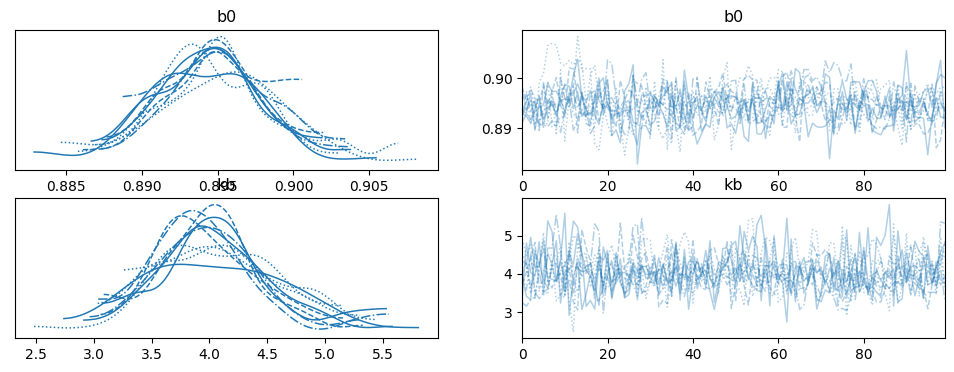

In [24]:
az.rcParams["plot.max_subplots"] = 200
axs = az.plot_trace(pyro_data)

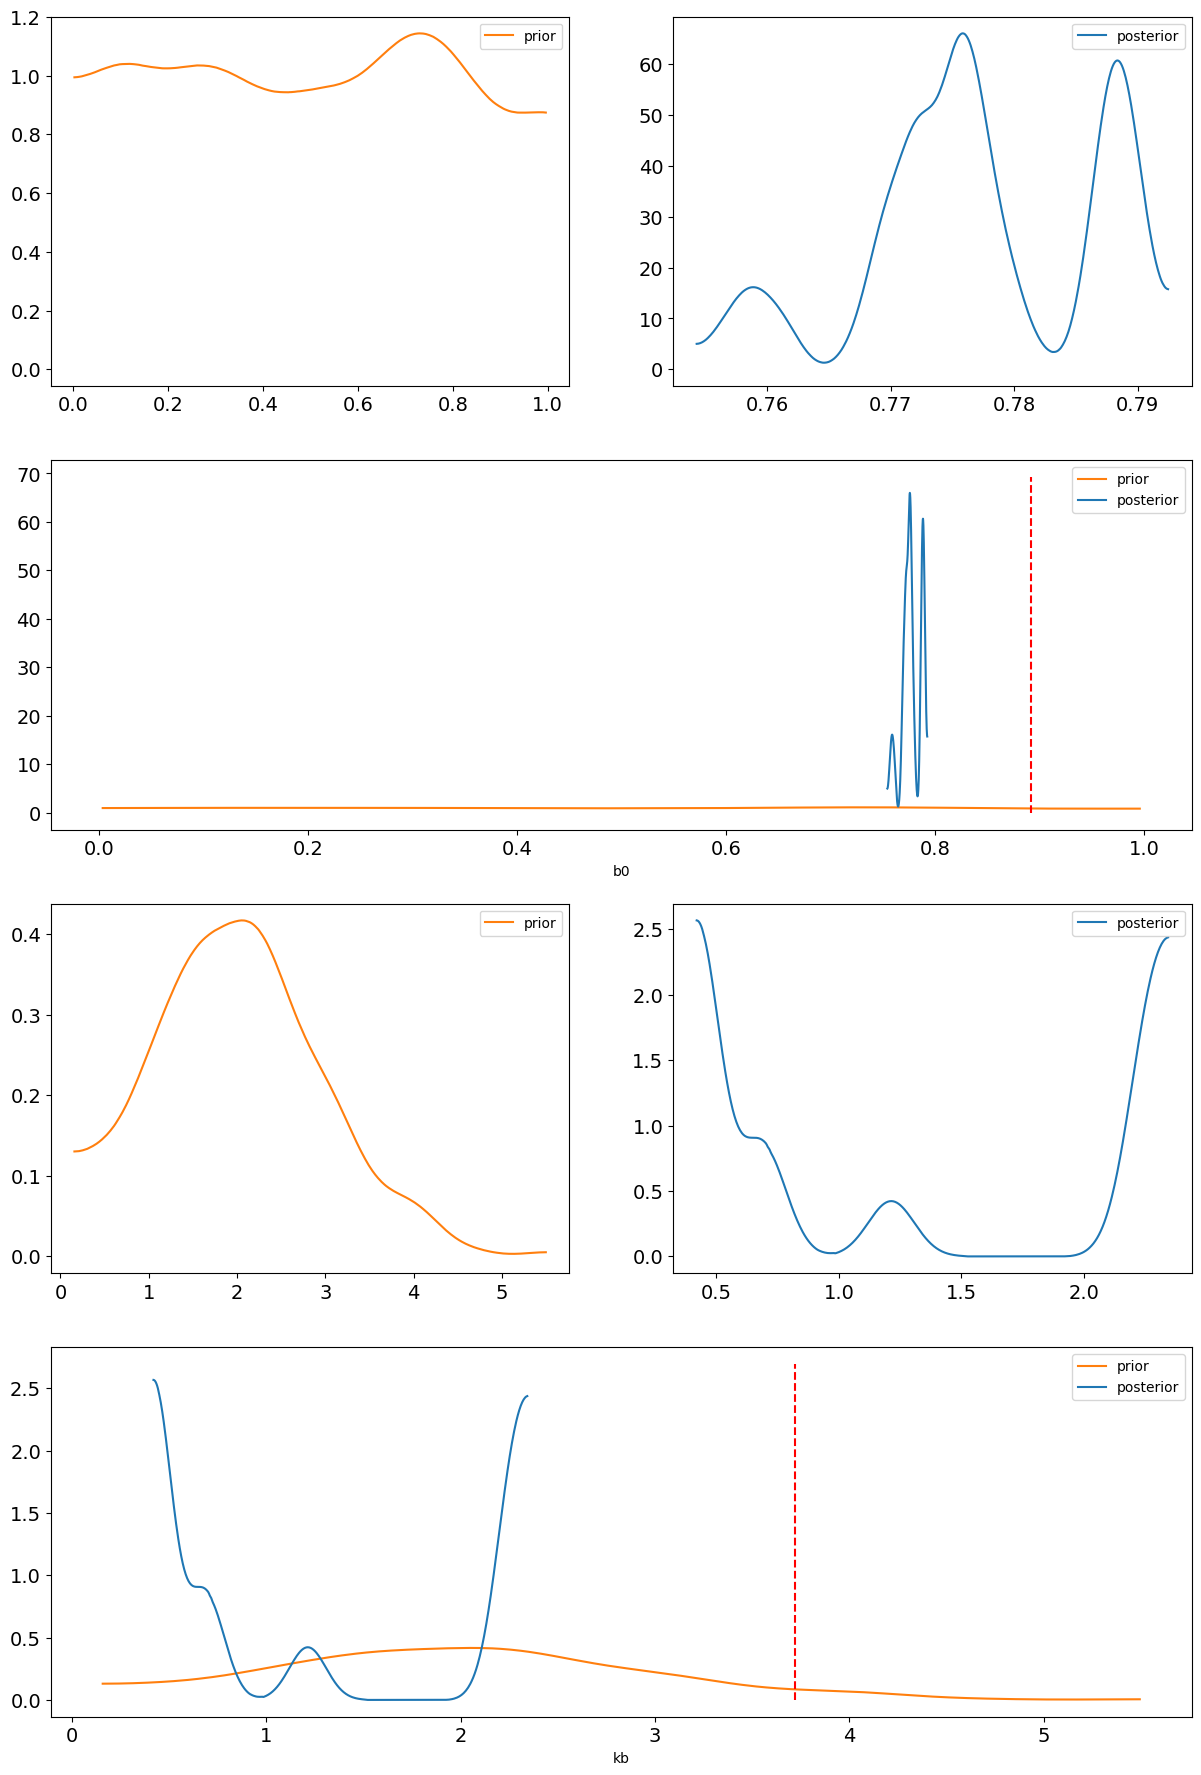

In [55]:
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )

In [56]:
posterior_predictive['obs']

Array([[ 919, 1044,    2, ...,  452,  106,   33],
       [ 919, 1044,    2, ...,  452,  106,   33],
       [ 919, 1044,    2, ...,  452,  106,   33],
       ...,
       [ 919, 1044,    2, ...,  452,  106,   33],
       [ 919, 1044,    2, ...,  452,  106,   33],
       [ 919, 1044,    2, ...,  452,  106,   33]], dtype=int64)

In [50]:
observations

Array([  919,  1044,     2,     3,    17, 28584, 18141,   176,   188,
          82, 50736, 28741,   409,   247,    66, 55406, 28485,   441,
         239,    47, 76070, 32728,   589,   144,    19, 79437, 33911,
         499,   142,    25, 85951, 37439,   452,   106,    33],      dtype=int64)

In [60]:
def prev(b0, kb, impl):
    return prev_stats_multisite([b0, kb], EIRs, etas, impl)[0]

In [94]:
from jax import value_and_grad

In [97]:
n = 50
b0 = jnp.linspace(0, 1, num=n)
kb = jnp.linspace(0, 5, num=n)
b0, kb = jnp.meshgrid(b0, kb)
dmeq_prev_space, dmeq_prev_grad = vmap(
    vmap(
        value_and_grad(prev),
        in_axes=(0, 0, None),
        out_axes=0
    ),
    in_axes=(1, 1, None),
    out_axes=1
)(b0, kb, dmeq.solve)
surr_prev_space, surr_prev_grad = vmap(
    vmap(
        value_and_grad(prev),
        in_axes=(0, 0, None),
        out_axes=0
    ),
    in_axes=(1, 1, None),
    out_axes=1
)(b0, kb, surrogate.run)

In [67]:
from matplotlib import cm

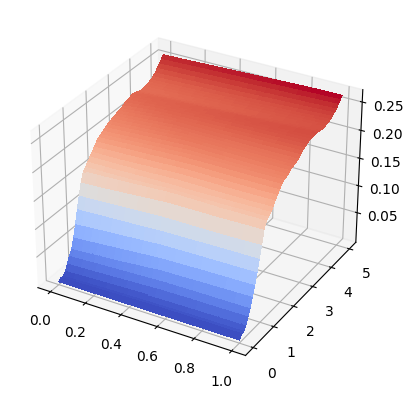

In [98]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, surr_prev_space, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

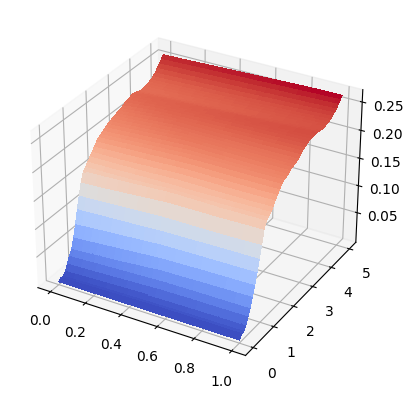

In [98]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, surr_prev_space, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)